In [1]:
import logging
import random

import networkx as nx
import osmnx as ox
from matplotlib import pyplot as plt

import proj as pj


stream = logging.StreamHandler()
pj.logger.addHandler(stream)
pj.logger.setLevel(logging.INFO)

/home/joaquin/.pyenv/versions/3.7.4/envs/enfoquedepulsos/lib/python3.7/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


## Get graph from OSM

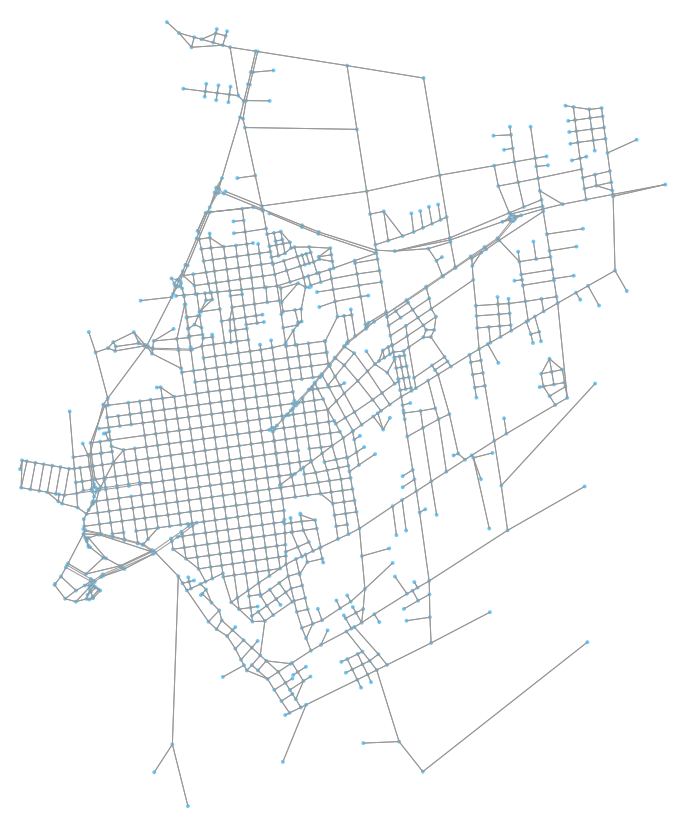

(<Figure size 1062.47x1080 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f570473a310>)

In [2]:
g = pj.graph.as_serializable(pj.graph.normalize_osm(ox.graph_from_place('Treinta y Tres, Treinta y Tres, Uruguay')))
ox.plot_graph(g, fig_height=15)

In [3]:
print(f'Nodes: {g.number_of_nodes()}')
print(f'Edges: {g.number_of_edges()}')
print(f'Multigraph: {g.is_multigraph()}')
print(f'Directed: {g.is_directed()}')

Nodes: 1358
Edges: 4132
Multigraph: True
Directed: True


In [7]:
odcount = 1
min_distance = 0.06
seed = 123

random.seed(seed)

nodes = list(g.nodes())
demand = {}
for _ in range(odcount):
    while True:
        ods = random.sample(nodes, k=2)
        if pj.geo.plane_distance(g, *ods) > min_distance:
            demand[tuple(ods)] = random.uniform(100, 2000)
            break

infras = {
    'cost_factors': [0.9, 0.5, 0.4],
    'construction_cost_factors': [1, 4, 8]
}
budget = 15000

In [8]:
pj.config.update_configuration(
    max_iter=1,
    arc_weight_key="length",
    budget_assignment_approach="demand",
    pulse_discard_faraway_nodes=True,
    solver_pulse_key_approach='avg_utility',
    use_astar_heuristic=False,
    solutions_per_od=1,
)

solution = pj.solve(g, infras, demand, budget)
solution.print()

Base primal bound per od {('1481701874', '1481702908'): 6733.437999999999}
INFO:proj:Base primal bound per od {('1481701874', '1481702908'): 6733.437999999999}



      Solution:
      3858362.5554400883

      Budget used: 24998.615999999995
      Modifications:
      {('1481701874', '1481702908'): {('1481701874', '1481701879', 0): 0, ('1481701879', '1481701880', 0): 0, ('1481701880', '1481701887', 0): 0, ('1481701887', '1481701894', 0): 0, ('1481701894', '2134400741', 0): 0, ('2134400741', '2134400742', 0): 0, ('2134400742', '1374290335', 0): 0, ('1374290335', '2134400746', 0): 0, ('2134400746', '2134400767', 3): 3863.6560000000004, ('2134400767', '2134400784', 3): 1145.064, ('2134400784', '6481886271', 3): 405.376, ('6481886271', '6481886268', 3): 1642.192, ('6481886268', '1481702058', 3): 1001.112, ('1481702058', '1481702123', 3): 3675.448, ('1481702123', '1481702142', 3): 1144.336, ('1481702142', '1673567530', 3): 1053.6, ('1673567530', '1481702187', 3): 1322.808, ('1481702187', '1481702230', 3): 665.136, ('1481702230', '1481702242', 3): 316.552, ('1481702242', '1481702282', 3): 531.864, ('1481702282', '1481702293', 3): 460.448, ('14817022

## Draw result

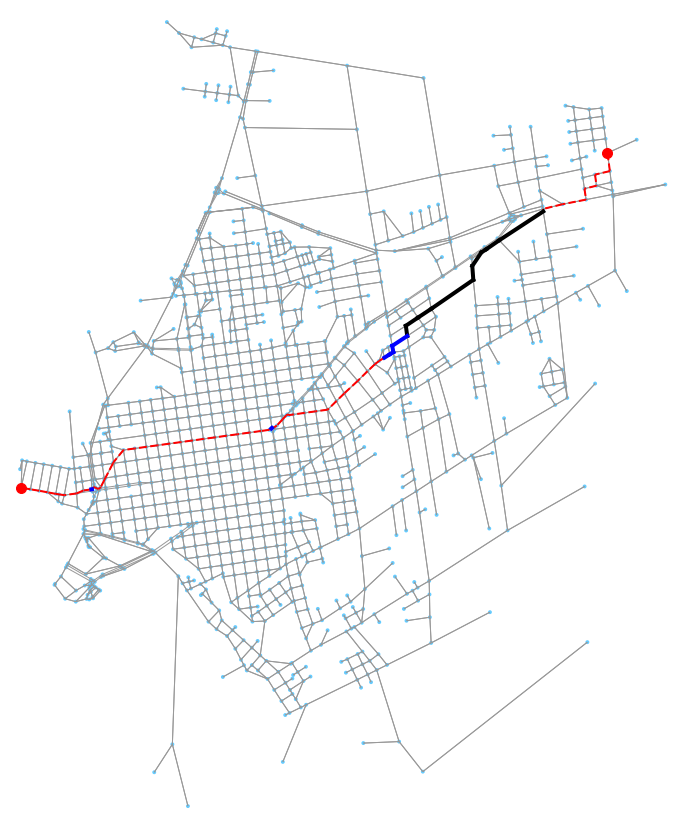

In [6]:
fig, ax = pj.osm.draw_solution(g, solution)